In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
plt.rcParams.update({'font.size': 15})
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
with open('data/training_set_ip_temp_20Hz_passive.p', 'rb') as fo:
        X_train = pickle.load(fo, encoding='bytes')
with open('data/training_set_op_temp_20Hz_passive.p', 'rb') as fo:
        Y_train = pickle.load(fo, encoding='bytes')
with open('data/testing_set_ip_temp_20Hz_passive.p', 'rb') as fo:
        X_test = pickle.load(fo, encoding='bytes')
with open('data/testing_set_op_temp_20Hz_passive.p', 'rb') as fo:
        Y_test = pickle.load(fo, encoding='bytes')

In [3]:
# pre-processing
## standardization
Y_train_std = np.empty_like(Y_train)
Y_test_std = np.empty_like(Y_test)
Y_train_std = (Y_train - np.mean(Y_train)) / np.std(Y_train)
Y_test_std = (Y_test - np.mean(Y_test)) / np.std(Y_test)

## change the input from the list to array
Nsyn = 9
time_dur = Y_train.shape[1]
def list2array(X):
    ip_dim = Nsyn
    ip_num = int(len(X) / ip_dim)
    X_array = np.zeros((ip_num, ip_dim, time_dur))
    for i in range(ip_num):
        for j in range(ip_dim):
            for spike_time in X[i*Nsyn+j]:
                if spike_time <= 1000:
                    X_array[i,j,int(spike_time)] += 1
    return X_array

X_train_std = list2array(X_train)
X_test_std = list2array(X_test)

## from numpy to pytorch
# Y_train_std = torch.tensor(Y_train_std)
# Y_train_std = Y_train_std.to(torch.float32)

# Y_test_std = torch.tensor(Y_test_std)
# Y_test_std = Y_test_std.to(torch.float32)

# X_train_std = torch.tensor(X_train_std)
# X_train_std = X_train_std.to(torch.float32)

# X_test_std = torch.tensor(X_test_std)
# X_test_std = X_test_std.to(torch.float32)
Y_train_std = torch.tensor(Y_train_std).to(device)
Y_train_std = Y_train_std.to(torch.float32)

Y_test_std = torch.tensor(Y_test_std).to(device)
Y_test_std = Y_test_std.to(torch.float32)

X_train_std = torch.tensor(X_train_std).to(device)
X_train_std = X_train_std.to(torch.float32)

X_test_std = torch.tensor(X_test_std).to(device)
X_test_std = X_test_std.to(torch.float32)

In [4]:
def kernel(time_dur, tau_rise, tau_decay):
    T = torch.arange(time_dur).to(device)
    y = (1 - torch.exp(-T / tau_rise)) * torch.exp(-T / tau_decay)
    return torch.flip(y, dims=[0])

def Kernel(time_dur, in_channels, Tau_rise, Tau_decay):
    y = torch.empty(1, in_channels, time_dur)
    for i in range(in_channels):
        y[0, i] = kernel(time_dur, Tau_rise[i], Tau_decay[i])
    return y.to(device)

In [1]:
class model(nn.Module):
    def __init__(self, time_dur, in_channels):
        super(model, self).__init__()
        self.time_dur = time_dur
        self.in_channels = in_channels
        weight = torch.ones((1, 9, 1), requires_grad=True) * 0.1
        self.weight = nn.Parameter(weight)
        Tau_rise = torch.ones(9, requires_grad=True) * 10
        self.Tau_rise = nn.Parameter(Tau_rise)
        Tau_decay = torch.ones(9, requires_grad=True) * 45
        self.Tau_decay = nn.Parameter(Tau_decay)
        c = torch.ones(1, requires_grad=True) * 35
        self.c = nn.Parameter(c)
        theta = torch.ones(1, requires_grad=True) * -0.59
        self.theta = nn.Parameter(theta)
        bias = torch.ones(1, requires_grad=True) * -26
        self.bias = nn.Parameter(bias)

    def forward(self, x):
        filter = Kernel(time_dur=self.time_dur, in_channels=self.in_channels, Tau_rise=self.Tau_rise, Tau_decay=self.Tau_decay) * self.weight
        x = F.conv1d(x, filter, padding=1000, bias=None)
        x = nn.Sigmoid()(x-self.theta) * self.c + self.bias
        x = torch.squeeze(x)[:, :self.time_dur]
        return x

NameError: name 'nn' is not defined

In [15]:
N_sample = X_train_std.shape[0]
in_channels = X_train_std.shape[1]
time_dur = X_train_std.shape[2]
net = model(time_dur, in_channels)
net.to(device)
error = nn.MSELoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

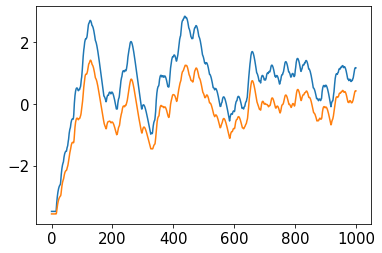

In [16]:
idx = 9
test = Variable(X_test_std)
output = net(test)
plt.plot(output[idx].cpu().detach().numpy())
plt.plot(Y_test_std[idx].cpu().detach().numpy())

In [14]:
output = net(train)
loss = error(output, tr_labels)
loss.backward()
print(net.weight.grad)
print(net.Tau_decay.grad)

tensor([[[7.8274],
         [7.3131],
         [7.8541],
         [8.6166],
         [7.8621],
         [7.7730],
         [7.7589],
         [7.7790],
         [7.7473]]], device='cuda:0')
tensor([0.0197, 0.0183, 0.0195, 0.0208, 0.0196, 0.0195, 0.0193, 0.0195, 0.0196],
       device='cuda:0')


In [19]:
# ANN model training
num_epochs = 1000
loss_train_list = []
iteration_list = []
loss_test_list = []
train = Variable(X_train_std)
tr_labels = Variable(Y_train_std)
test = Variable(X_test_std)
test_labels = Variable(Y_test_std)

for epoch in range(num_epochs):
    outputs = net(train) # Forward propagation
    loss_train = error(outputs, tr_labels) # Calculate loss
    loss_train.backward() # Calculating gradients
    #loss_train.backward(retain_graph=True) 
    optimizer.step() # Update parameters
    optimizer.zero_grad() # Clear gradients
        
    if epoch % 50 == 0:        
        # Predict test dataset
        outputs = net(test) # Forward propagation
        loss_test = error(outputs, test_labels)
        # store loss and iteration
        loss_train_list.append(loss_train.data.item())
        iteration_list.append(epoch)
        loss_test_list.append(loss_test.data.item())
    if epoch % 50 == 0:
        print('Iteration: {}  Train_Loss: {}  Test_Loss: {}'.format(epoch, loss_train.data.item(), loss_test.data.item()))
print('Final: Train_Loss: {}  Test_Loss: {}'.format(loss_train.data.item(), loss_test.data.item()))

Iteration: 0  Train_Loss: 1.0094325542449951  Test_Loss: 1.0092190504074097
Iteration: 50  Train_Loss: 1.008996844291687  Test_Loss: 1.0087937116622925
Iteration: 100  Train_Loss: 1.008599877357483  Test_Loss: 1.008406162261963
Iteration: 150  Train_Loss: 1.0082366466522217  Test_Loss: 1.0080516338348389
Iteration: 200  Train_Loss: 1.007902979850769  Test_Loss: 1.0077258348464966
Iteration: 250  Train_Loss: 1.0075955390930176  Test_Loss: 1.0074257850646973


KeyboardInterrupt: 

In [18]:
for i in net.parameters():
    print(i)

Parameter containing:
tensor([[[-1.8176],
         [-1.6880],
         [-1.8174],
         [-2.0186],
         [-1.8020],
         [-1.7979],
         [-1.7849],
         [-1.7834],
         [-1.8047]]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([10.0194, 10.0166, 10.0174, 10.0142, 10.0195, 10.0188, 10.0195, 10.0215,
        10.0202], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([44.9640, 44.9686, 44.9631, 44.9674, 44.9658, 44.9624, 44.9634, 44.9655,
        44.9637], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([31.1595], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([5.6272], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0014], device='cuda:0', requires_grad=True)


In [10]:
print(net.weight.grad)
print(net.Tau_decay.grad)


tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


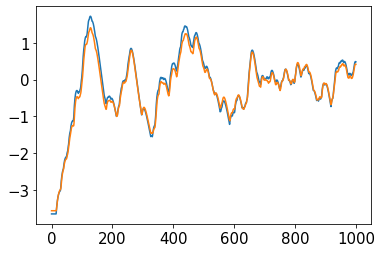

In [11]:
idx = -1
output = net(test)
plt.plot(output[idx].cpu().detach().numpy())
plt.plot(Y_test_std[idx].cpu().detach().numpy())

In [61]:
class model(nn.Module):
    def __init__(self, time_dur, in_channels):
        super(model, self).__init__()
        self.time_dur = time_dur
        self.in_channels = in_channels
        Tau_rise = torch.rand(9, requires_grad=True)
        self.Tau_rise = nn.Parameter(Tau_rise)
        Tau_decay = torch.rand(9, requires_grad=True)
        self.Tau_decay = nn.Parameter(Tau_decay)
        self.filters = Kernel(time_dur=self.time_dur, in_channels=self.in_channels, Tau_rise=self.Tau_rise, Tau_decay=self.Tau_decay)
        weight = torch.rand((1, 9, 1), requires_grad=True)
        self.weight = nn.Parameter(weight)
        self.filters = self.filters * self.weight
        bias = torch.randn(1, requires_grad=True)
        self.bias = nn.Parameter(bias)

    def forward(self, inputs):
        y = F.conv1d(inputs, self.filters, padding=1000, bias=self.bias)
        y = torch.squeeze(y)[:, :self.time_dur]
        return y

In [64]:
net = model(time_dur, in_channels)
net.filters.requires_grad

True

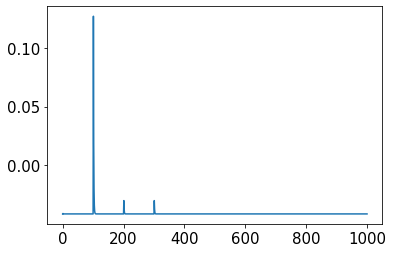

In [48]:
net = model(1001, 9)
input = torch.zeros(10, 9, 1001)
input[0, 0, 0] = 1
input[0, 1, 100] = 1
input[0, 2, 200] = 1
input[0, 2, 300] = 1
output = net(input)
plt.plot(output[0].detach().numpy())

In [57]:
N_sample = X_train_std.shape[0]
in_channels = X_train_std.shape[1]
time_dur = X_train_std.shape[2]
net = model(time_dur, in_channels)
error = nn.MSELoss()
learning_rate = 10
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

In [62]:
train = Variable(X_train_std)
tr_labels = Variable(Y_train_std)
test = Variable(X_test_std)
test_labels = Variable(Y_test_std)

outputs = net(train)
optimizer.zero_grad()
loss_train = error(outputs, tr_labels)
# print(net.weight.data)
# print(net.weight.grad)
print(net.Tau_rise.data)
print(net.Tau_rise.grad)
#loss_train.backward(retain_graph=True)
loss_train.backward()
optimizer.step()
# print(net.weight.data)
# print(net.weight.grad)
print(net.Tau_rise.data)
print(net.Tau_rise.grad)


tensor([0.7840, 0.7091, 0.4188, 0.7012, 0.7966, 0.1629, 0.5551, 0.1552, 0.7920])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])


RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling backward the first time.

In [60]:
for epoch in range(num_epochs):
    outputs = net(train) # Forward propagation
    loss_train = error(outputs, tr_labels) # Calculate loss
    optimizer.zero_grad() # Clear gradients
    #loss_train.backward() # Calculating gradients
    loss_train.backward(retain_graph=True) 
    optimizer.step() # Update parameters

RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling backward the first time.